# **Data Augmentation** using Variational Autoencoder

This notebook will guide you trough the use of a variational convolutional autoencoder in the task of data augmentation. The main objective is to use a convolutional autoencoder to reconstruct of the **"2"** images in the MNIST database in order to augment a database. (You can try different digits)

## A little bit about Autoencoder in general

Autoencoder's goal is to learn how to reconstruct the input-data. But how is it helpful? The trick is their structure. The first part of the network is what we refer to as the Encoder. It receives the input and it encodes it in a latent space of a lower dimension. The second part (the Decoder) takes that vector and decode it in order to produce the original input.

Therefore, we can apply them to reproduce the same but a little different or even better data. Examples are:

***Data Denoising***: Feed them with a noisy image and train them to output the same image but without the noise

***Training data augmentation***

***Anomaly Detection***: Train them on a single class so that every anomaly gives a large reconstruction error.

Variational autoencoders are trained to learn the probability distribution that models the input-data and not the function that maps the input and the output. It then samples points from this distribution and feed them to the decoder to generate new input data samples.

One of the key aspects of VAE is the **loss function**. Most commonly, it consists of two components. The reconstruction loss measures how different the reconstructed data are from the original data (binary cross entropy for example).
[Reference : Sergios Karagiannakos]





### Load the packages

In [1]:
# ============== Packages ===================
#%%capture
%pip install bff
%pip install --upgrade tensorflow
import re
import bff
import math
import pickle
import pprint
import statistics
import numpy as np
import collections
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import bff.plot as bplt
from pathlib import Path
import matplotlib as mpl
from itertools import cycle
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn import preprocessing
import matplotlib.patches as mpatches
from typing import Callable, Dict, List, Sequence, Tuple, Union
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Imports for model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse, binary_crossentropy, MeanSquaredError
from tensorflow.keras.layers import Layer, Dense, Reshape, Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, UpSampling2D

Note: you may need to restart the kernel to use updated packages.


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Requirement already up-to-date: tensorflow in c:\users\kurokabe\appdata\local\programs\python\python37\lib\site-packages (2.0.0)
Note: you may need to restart the kernel to use updated packages.


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Loading MNIST dataset for digit "***2***"

The MNIST is database of handwritten digits. The digits have been size-normalized and centered in a fixed-size image.

In this section we also split our data into training and testing datasets.

You are able to observe different digits.


In [2]:
# Loading MNIST dataset for especific number, you can change digit in num variable
num = 8

# MNIST dataset.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select only number that choose in num.
train_filter = np.where((y_train == num))
test_filter = np.where((y_test == num))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

print(f'Size of train: {y_train.shape}')
print(f'Size of test: {y_test.shape}')

# Resize the images and normalize between [0, 1].
image_size = x_train.shape[1]
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32') / 255
print(f'Shape of training: {x_train.shape}')
print(f'Shape of testing: {x_test.shape}')

Size of train: (5851,)
Size of test: (974,)
Shape of training: (5851, 28, 28, 1)
Shape of testing: (974, 28, 28, 1)


### Examples of digit ***"2"*** from dataset

100%|██████████| 100/100 [00:00<00:00, 2748.42it/s]


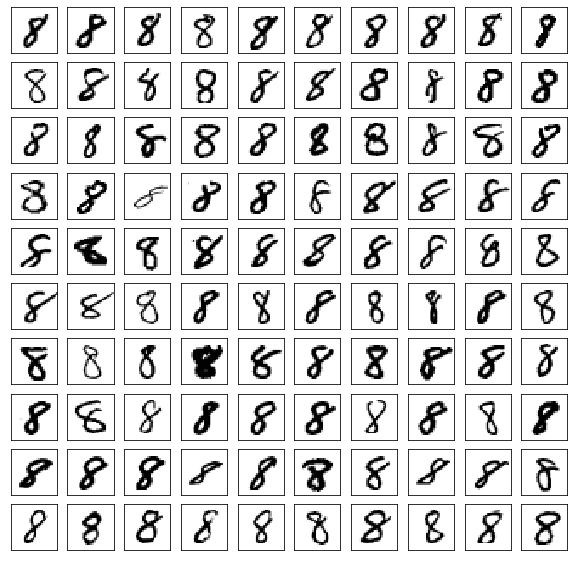

In [3]:
# Examples of 2
_, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(tqdm(axes.flatten())):
  ax.xaxis.set_major_locator(plt.NullLocator())
  ax.yaxis.set_major_locator(plt.NullLocator())
  if len(x_train.shape) < 3:
      size = int(np.sqrt(x_train[i].shape[0]))
  else:
      size = x_train.shape[1]
  ax.imshow(x_train[i].reshape(size, size), cmap='gray_r')


### Reconstructing Variational Autoencoder


In [4]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a serie."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # By default, random_normal has mean=0 and std=1.0.
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(Layer):
    """Maps series to a triplet (z_mean, z_log_var, z)."""

    def __init__(self,
                 latent_dim=2,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.conv_1 = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')
        self.flatten = Flatten()
        self.dense_before_latent = Dense(16, activation='relu')
        self.dense_mean = Dense(latent_dim, name='z_mean')
        self.dense_log_var = Dense(latent_dim, name='z_log_var')
        self.sampling = Sampling()
  
    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        shape = K.int_shape(x)
        #print(K.int_shape(x))
        # Generate latent vector.
        x = self.flatten(x)
        x = self.dense_before_latent(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(Layer):
    """Converts z, the encoded vector, back into a readable series."""
  
    def __init__(self,
                 original_dim,
                 name='decoder',
                 **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = Dense(7*7*64, activation='relu')
        self.reshape = Reshape(target_shape=(7, 7, 64))
        self.conv_1 = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv_2 = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv_output = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same')
  
    def call(self, inputs):
        x = self.dense_proj(inputs)
        x = self.reshape(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        return self.conv_output(x)


class VariationalAutoEncoder(Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
  
    def __init__(self,
                 original_dim,
                 latent_dim=32,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(original_dim)
  
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Add KL divergence regularization loss.
        reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(reconstructed))
        reconstruction_loss *= self.original_dim
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(vae_loss)
        
        return reconstructed

### Different sizes of dataset for fitting the variational autoencoder

In this step, you fit variational autoencoder model to different sizes of train dataset:

1.   *whole dataset*
2.   *1000 samples of dataset*
3.   *100 samples of dataset*
4.   *10 samples of dataset*


Observe different sizes of samples and their model losses.


In [5]:
models = {}

training_sizes = [x_train.shape[0], 1000, 100, 10] # different sizes of train dataset

for size_training in training_sizes:
    #size_training = x_train.shape[0]
    x_train_filter = x_train[:size_training]

    print(f'Training using {size_training} examples.')
    print(f'Shape of training: {x_train_filter.shape}')

    # Size of layers
    original_dim = x_train_filter.shape[1] # Should be 784.
    latent_dim = 2

    # Parameters for training.
    batch_size = 16 if size_training > 100 else 1
    epochs = 50

    vae = VariationalAutoEncoder(original_dim, 
                                 latent_dim=latent_dim)

    optimizer = Adam(learning_rate=1e-3)

    # Define the Keras TensorBoard callback.
    #logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    # Losses are MSE with KL divergence.
    vae.compile(optimizer)
    history = vae.fit(x_train_filter,
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_split=0.2, 
                      verbose=1)
                      #callbacks=[tensorboard_callback])
    #plot_model(vae, to_file='vae-cnn.png')
    vae.summary()
    
    models[size_training] = (history, vae)


#plot_model(vae, to_file='11-VAE_MLP_-OBJ.png', show_shapes=True, expand_nested=True)



Training using 5851 examples.
Shape of training: (5851, 28, 28, 1)


2019-12-16 12:45:29,675 [WARNING] tensorflow: Output output_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to output_1.


Train on 4680 samples, validate on 1171 samples
Epoch 1/50
4680/4680 [==============================] - 4s 779us/sample - loss: 8.3394 - val_loss: 6.9075
Epoch 2/50
4680/4680 [==============================] - 3s 603us/sample - loss: 6.9287 - val_loss: 6.7079
Epoch 3/50
4680/4680 [==============================] - 3s 663us/sample - loss: 6.8343 - val_loss: 6.6868
Epoch 4/50
4680/4680 [==============================] - 3s 636us/sample - loss: 6.8156 - val_loss: 6.6656
Epoch 5/50
4680/4680 [==============================] - 3s 605us/sample - loss: 6.8146 - val_loss: 6.6699
Epoch 6/50
4680/4680 [==============================] - 3s 618us/sample - loss: 6.8088 - val_loss: 6.6316
Epoch 7/50
4680/4680 [==============================] - 3s 601us/sample - loss: 6.8053 - val_loss: 6.6469
Epoch 8/50
4680/4680 [==============================] - 3s 603us/sample - loss: 6.8035 - val_loss: 6.6576
Epoch 9/50
4680/4680 [==============================] - 3s 605us/sample - loss: 6.7988 - val_loss: 6.757

2019-12-16 12:47:53,087 [WARNING] tensorflow: Output output_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to output_1.


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  69076     
_________________________________________________________________
decoder (Decoder)            multiple                  65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________
Training using 1000 examples.
Shape of training: (1000, 28, 28, 1)
Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 1ms/sample - loss: 12.2766 - val_loss: 8.0383
Epoch 2/50
800/800 [==============================] - 0s 592us/sample - loss: 7.4719 - val_loss: 7.3181
Epoch 3/50
800/800 [==============================] - 0s 572us/sample - loss: 7.2054 - val_loss: 7.1564
Epoch 4/50
800/800 [==============================] - 0s 577us/sample - loss: 7.0719 - 

2019-12-16 12:48:17,553 [WARNING] tensorflow: Output output_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to output_1.


Train on 80 samples, validate on 20 samples
Epoch 1/50
80/80 [==============================] - 1s 10ms/sample - loss: 11.7253 - val_loss: 7.1142
Epoch 2/50
80/80 [==============================] - 0s 2ms/sample - loss: 7.1211 - val_loss: 6.5423
Epoch 3/50
80/80 [==============================] - 0s 2ms/sample - loss: 6.9302 - val_loss: 6.4971
Epoch 4/50
80/80 [==============================] - 0s 2ms/sample - loss: 6.7404 - val_loss: 6.3137
Epoch 5/50
80/80 [==============================] - 0s 2ms/sample - loss: 6.7871 - val_loss: 6.4263
Epoch 6/50
80/80 [==============================] - 0s 2ms/sample - loss: 6.6775 - val_loss: 6.2670
Epoch 7/50
80/80 [==============================] - 0s 2ms/sample - loss: 6.5399 - val_loss: 6.3044
Epoch 8/50
80/80 [==============================] - 0s 2ms/sample - loss: 6.4771 - val_loss: 6.2389
Epoch 9/50
80/80 [==============================] - 0s 2ms/sample - loss: 6.5160 - val_loss: 6.3228
Epoch 10/50
80/80 [==============================] - 0

2019-12-16 12:48:28,087 [WARNING] tensorflow: Output output_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to output_1.


Train on 8 samples, validate on 2 samples
Epoch 1/50
8/8 [==============================] - 1s 85ms/sample - loss: 18.9861 - val_loss: 18.0799
Epoch 2/50
8/8 [==============================] - 0s 3ms/sample - loss: 17.1465 - val_loss: 15.5329
Epoch 3/50
8/8 [==============================] - 0s 3ms/sample - loss: 12.6821 - val_loss: 11.2882
Epoch 4/50
8/8 [==============================] - 0s 3ms/sample - loss: 10.9960 - val_loss: 9.4982
Epoch 5/50
8/8 [==============================] - 0s 3ms/sample - loss: 9.7905 - val_loss: 8.2112
Epoch 6/50
8/8 [==============================] - 0s 3ms/sample - loss: 8.9629 - val_loss: 7.8097
Epoch 7/50
8/8 [==============================] - 0s 3ms/sample - loss: 7.8731 - val_loss: 6.8048
Epoch 8/50
8/8 [==============================] - 0s 3ms/sample - loss: 7.2674 - val_loss: 6.1384
Epoch 9/50
8/8 [==============================] - 0s 3ms/sample - loss: 7.1837 - val_loss: 5.8714
Epoch 10/50
8/8 [==============================] - 0s 3ms/sample - l

### Model Loss
Model losses for 4 different dataset.

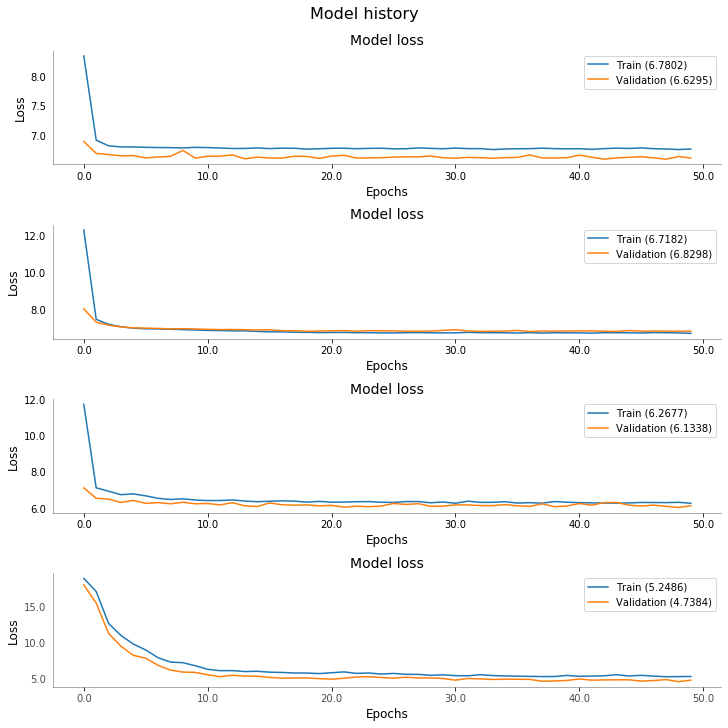

In [6]:
_, axes = plt.subplots(nrows=len(training_sizes), ncols=1, figsize=(10, 10), constrained_layout=True)
axes = axes.flatten()

for i, size in enumerate(training_sizes):
    history = models[size][0]
    history.history['val_loss'] = history.history.get('val_loss', [0])
    bplt.plot_history(history.history, axes=axes[i])

### Uploading pretrained model that can predict digits.
Uploading pretrained model in order to see how much the variational autoencoder were successful in reconstructing digits that can be recognize by MNIST model.

You need to upload **cnn.h5** file inside **Models** folder from provided folder.

In [7]:
# Loading a pretrained model
model_mnist = load_model('./models/cnn.h5')
model_mnist.summary()

2019-12-16 12:48:31,222 [WARNING] tensorflow: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

### **Predictions based on different sizes of dataset**

In [8]:
def predict_digit(model_mnist, img):
    digits = np.squeeze(model_mnist.predict(img))
    digit = np.where(digits == np.amax(digits))[0][0]
    return digit

100%|██████████| 100/100 [00:02<00:00, 45.71it/s]


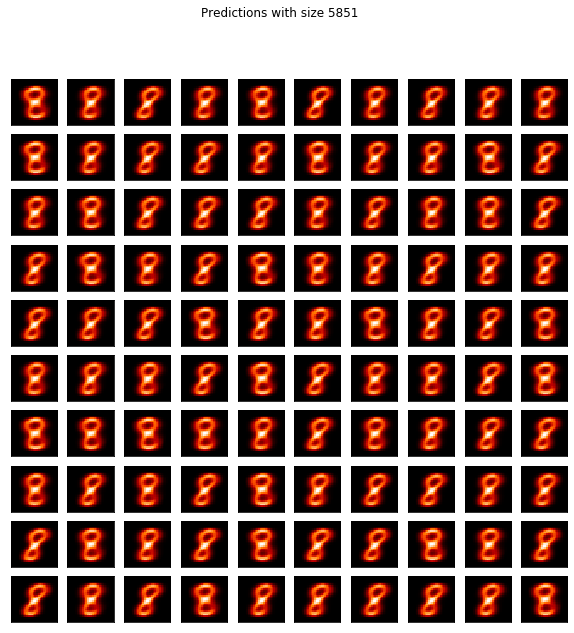

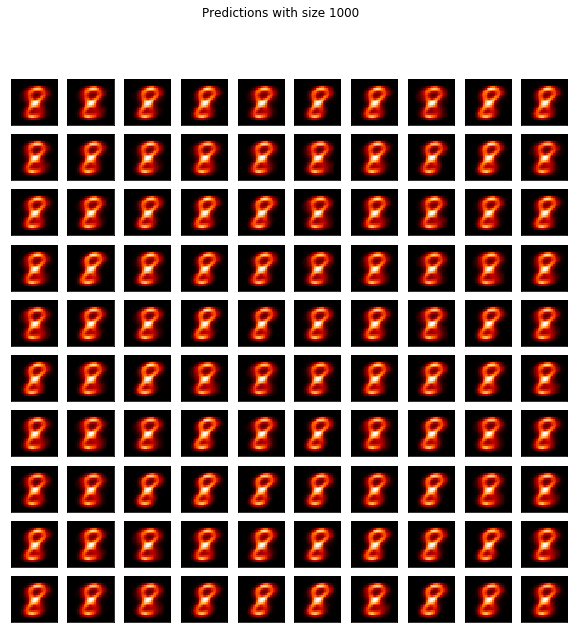

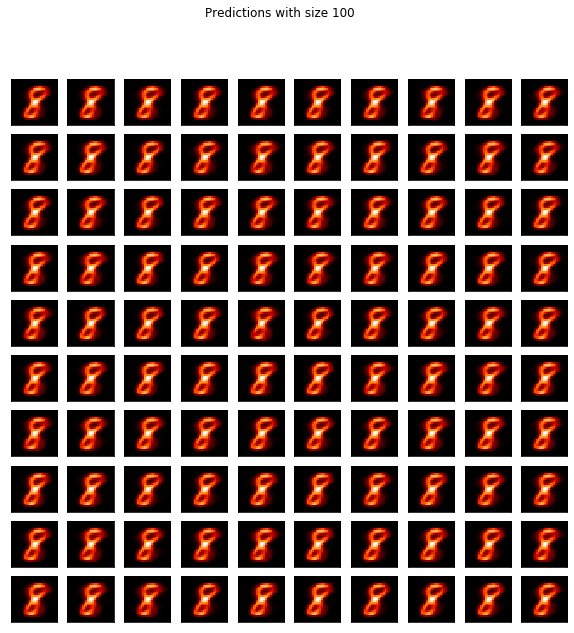

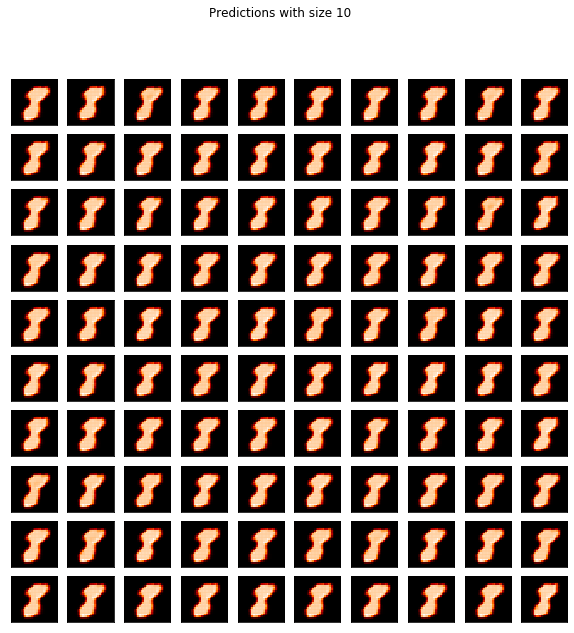

In [9]:
COLORS = ['spring', 'Wistia', 'gray', 'summer', 'hot',
          'winter', 'afmhot', 'autumn', 'gist_heat', 'copper'] # colormap for digits from 0 to 9

for size_train, (_, vae) in models.items():
    # Example of digits from dataset.
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))

    # Create random numbers for the decoder.
    randoms = np.array([np.random.uniform(-2, 2, latent_dim) for _ in range(10 * 10)]).astype('float32')
    predictions = vae.decoder(randoms).numpy()

    for i, ax in enumerate(tqdm(axes.flatten())):
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        if len(x_test.shape) < 3:
            size = int(np.sqrt(x_test[i].shape[0]))
        else:
            size = x_test.shape[1]
        ax.imshow(predictions[i].reshape(size, size), cmap=COLORS[predict_digit(model_mnist, np.expand_dims(predictions[i], axis=0))])
    fig.suptitle(f'Predictions with size {size_train}')

#### Try to change the latent layer to observe how classifying digits with MNIST model is gonna change.

2019-12-16 12:48:49,283 [WARNING] tensorflow: Layer decoder is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2019-12-16 12:48:55,755 [WARNING] tensorflow: Layer decoder is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended

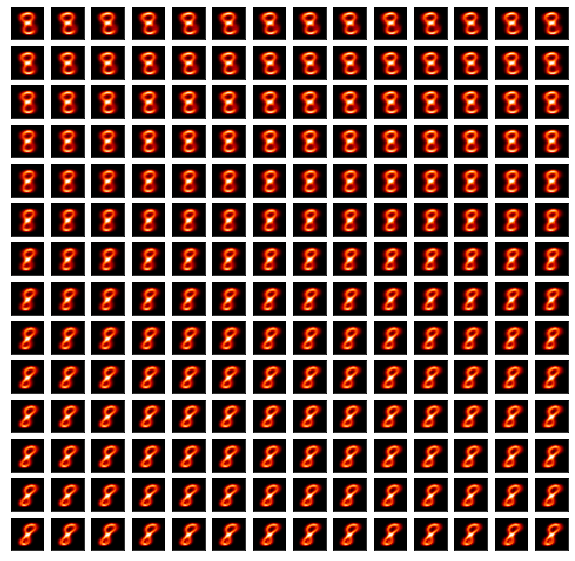

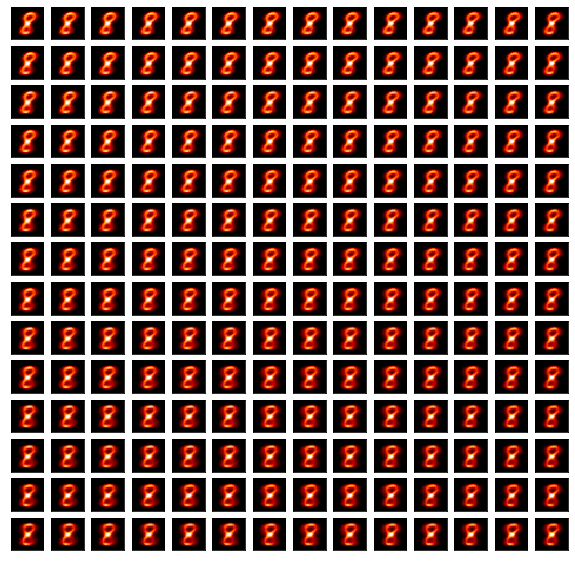

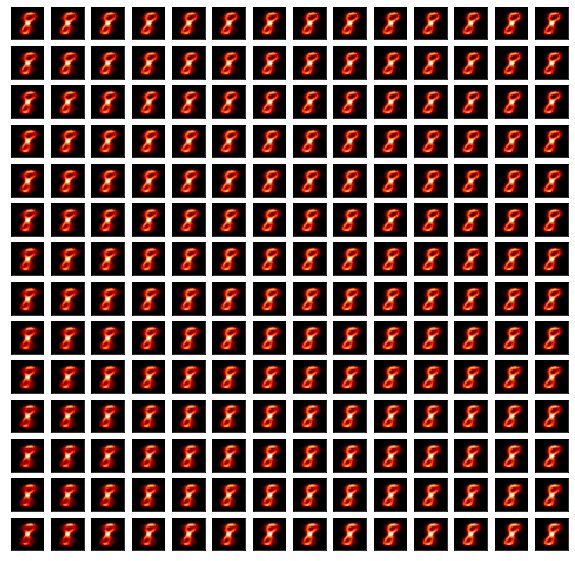

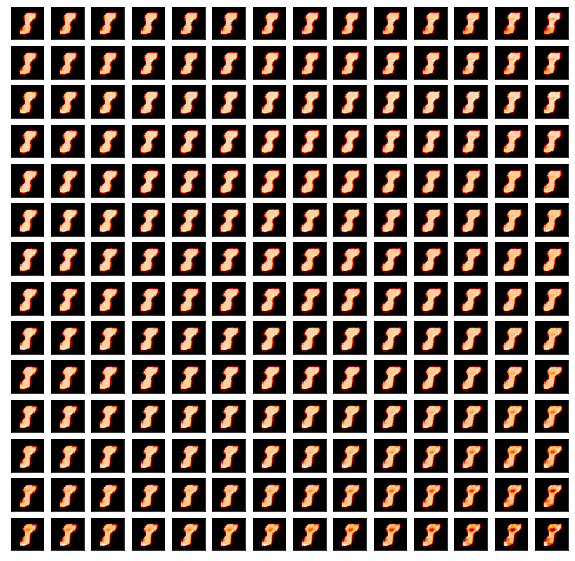

In [10]:
for size_train, (_, vae) in models.items():
    _, axes = plt.subplots(14, 14, figsize=(10, 10))

    # Create random numbers for the decoder.
    values = np.arange(-3, 4, .5)
    xx, yy = np.meshgrid(values, values)
    input_holder = np.zeros((1, latent_dim))

    for row in range(xx.shape[0]):
        for col in range(xx.shape[1]):
            input_holder[0, :] = [xx[row, col], yy[row, col]]
            axes[row][col].xaxis.set_major_locator(plt.NullLocator())
            axes[row][col].yaxis.set_major_locator(plt.NullLocator())
            img = vae.decoder(input_holder).numpy()

            digit = predict_digit(model_mnist, img)

            axes[row][col].imshow(img.reshape(size, size), cmap=COLORS[digit])



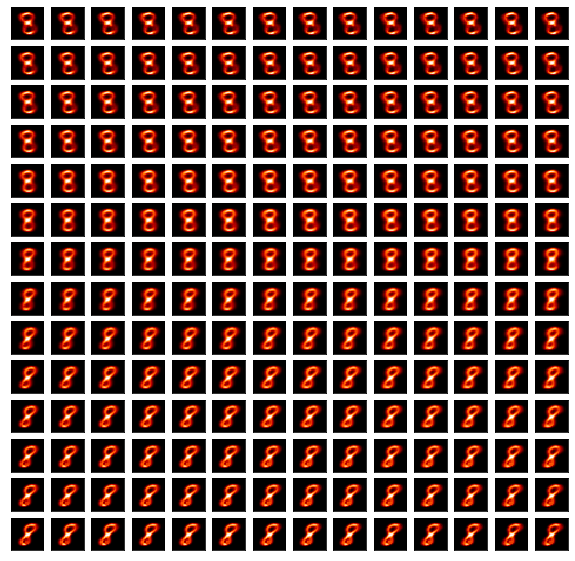

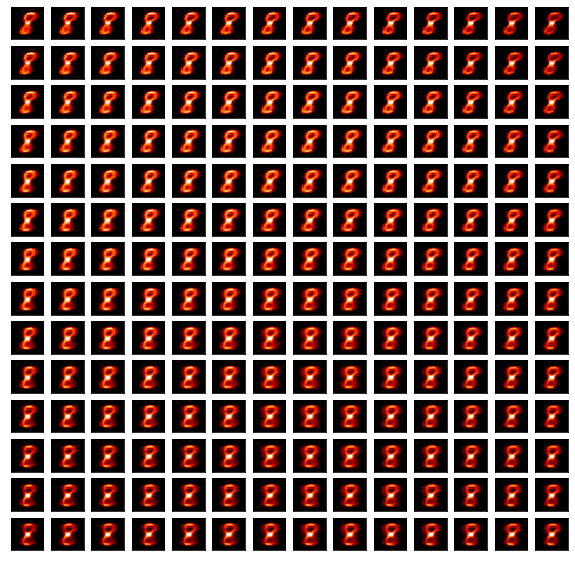

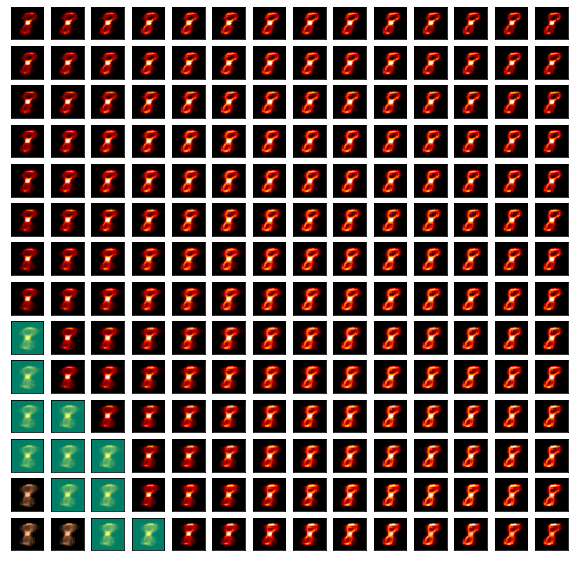

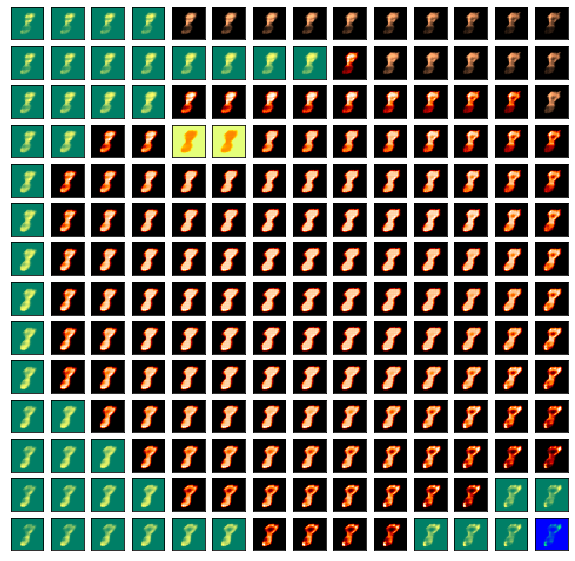

In [11]:
for size_train, (_, vae) in models.items():
    _, axes = plt.subplots(14, 14, figsize=(10, 10))

    # Create random numbers for the decoder.
    values = np.arange(-7, 7, 1)
    xx, yy = np.meshgrid(values, values)
    input_holder = np.zeros((1, latent_dim))

    for row in range(xx.shape[0]):
        for col in range(xx.shape[1]):
            input_holder[0, :] = [xx[row, col], yy[row, col]]
            axes[row][col].xaxis.set_major_locator(plt.NullLocator())
            axes[row][col].yaxis.set_major_locator(plt.NullLocator())
            img = vae.decoder(input_holder).numpy()

            digit = predict_digit(model_mnist, img)

            axes[row][col].imshow(img.reshape(size, size), cmap=COLORS[digit])

